*KELOMPOK2_FIBONACCI***
1. Vica Acnia Fratiwi
2. Frans Aldi Gurning
3. Ahmad Hardiansyah	
4. Keisya Uthi Tabitha
5. Irma Suryani

# Modulus dan Packeges

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"keisyauthitabitha","key":"c62aac5adfefb4b7d74f2fea2ff2dcf5"}'}

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Import Data

In [ ]:
!kaggle datasets download -d dodyharianto/sunibatik-dataset

 98% 276M/281M [00:02<00:00, 131MB/s]
100% 281M/281M [00:02<00:00, 103MB/s]


In [ ]:
import zipfile,os
local_zip = '/content/sunibatik-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/batik')
zip_ref.close()

In [ ]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from IPython.display import Image
import imutils   

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

import keras
import tensorflow.keras as K

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img, img_to_array
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import imutils    

In [ ]:
#specify directory
train_dir = '/content/batik/MainDataset/TRAIN'
test_dir = '/content/batik/MainDataset/TEST'

In [ ]:
#create classes
classes = os.listdir('/content/batik/MainDataset/TRAIN')

# Exploratory Data Analysis (EDA)

In [ ]:
classes

['Batik Geblek Renteng',
 'Batik Bali',
 'Batik Poleng',
 'Batik Parang',
 'Batik Betawi',
 'Batik Insang',
 'Batik Kawung',
 'Batik Lasem',
 'Batik Megamendung',
 'Batik Pala',
 'Batik Cendrawasih',
 'Batik Dayak',
 'Batik Ikat Celup',
 'Batik Sekar Jagad',
 'Batik Tambal']

In [ ]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=42,
    image_size=(224, 224),
    batch_size=32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=42,
    image_size=(224, 224),
    batch_size=32)

Found 3838 files belonging to 15 classes.
Found 714 files belonging to 15 classes.


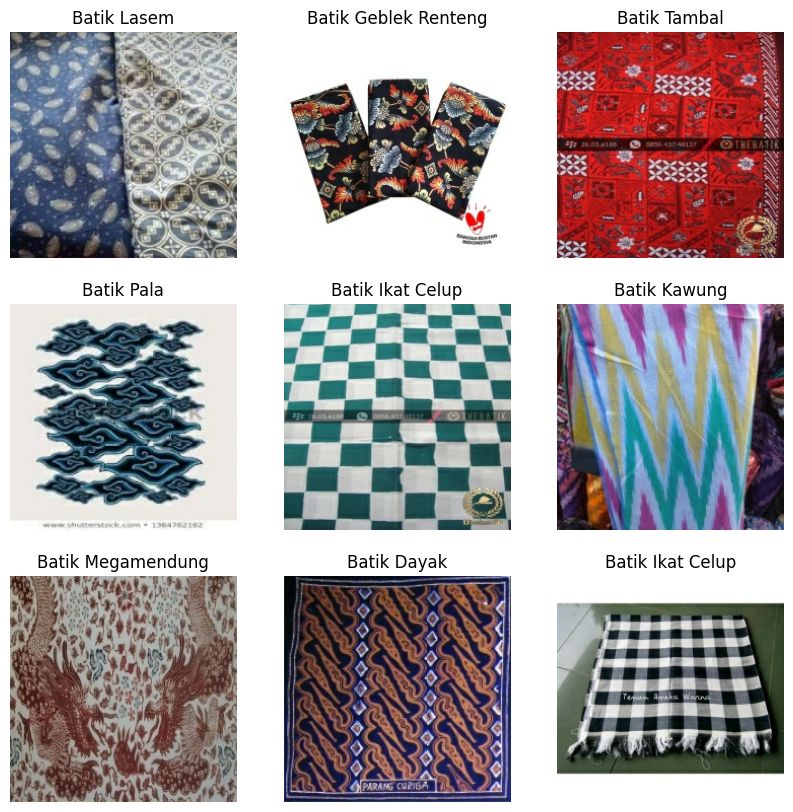

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

In [ ]:
#check the number of images in each class in the training dataset
No_images_per_class = []
Class_name = []

for i in os.listdir('/content/batik/MainDataset/TRAIN'):
  train_class = os.listdir(os.path.join('/content/batik/MainDataset/TRAIN', i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))

Number of images in Batik Geblek Renteng = 194 

Number of images in Batik Bali = 210 

Number of images in Batik Poleng = 240 

Number of images in Batik Parang = 250 

Number of images in Batik Betawi = 210 

Number of images in Batik Insang = 240 

Number of images in Batik Kawung = 463 

Number of images in Batik Lasem = 210 

Number of images in Batik Megamendung = 440 

Number of images in Batik Pala = 199 

Number of images in Batik Cendrawasih = 246 

Number of images in Batik Dayak = 239 

Number of images in Batik Ikat Celup = 252 

Number of images in Batik Sekar Jagad = 204 

Number of images in Batik Tambal = 241 



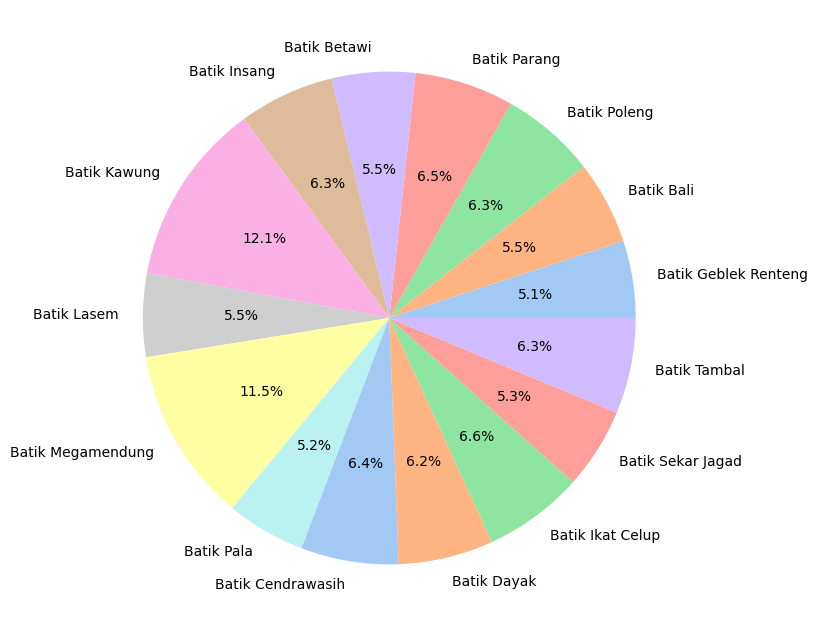

In [ ]:
#visualize class distribution in train set
plt.figure(figsize=(8, 8))
colors = sns.color_palette('pastel')
plt.pie(No_images_per_class, 
        labels = Class_name, 
        autopct = '%1.1f%%',
        colors=colors)
plt.show()

# Menyiapkan Data

In [ ]:
#use Image Data Generator to perform this task
#train set
datagen = ImageDataGenerator(rotation_range=10,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             validation_split=0.2)                                     

In [ ]:
train_data = datagen.flow_from_directory('/content/batik/MainDataset/TRAIN',
                                         target_size=(224, 224),
                                         batch_size=32,
                                         class_mode='categorical',
                                         subset='training')

valid_data = datagen.flow_from_directory('/content/batik/MainDataset/VALIDATION',
                                         target_size=(224, 224),
                                         batch_size=32,
                                         class_mode='categorical',
                                         subset='validation')

#test set
test_datagen = ImageDataGenerator()

test_data = datagen.flow_from_directory('/content/batik/MainDataset/TEST',
                                         target_size=(224, 224),
                                        class_mode='categorical',
                                        shuffle=False)

Found 3075 images belonging to 15 classes.
Found 217 images belonging to 15 classes.
Found 714 images belonging to 15 classes.


In [ ]:
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32, 15)


In [ ]:
#view the class dictionary
print(train_data.class_indices)
print(test_data.class_indices)

{'Batik Bali': 0, 'Batik Betawi': 1, 'Batik Cendrawasih': 2, 'Batik Dayak': 3, 'Batik Geblek Renteng': 4, 'Batik Ikat Celup': 5, 'Batik Insang': 6, 'Batik Kawung': 7, 'Batik Lasem': 8, 'Batik Megamendung': 9, 'Batik Pala': 10, 'Batik Parang': 11, 'Batik Poleng': 12, 'Batik Sekar Jagad': 13, 'Batik Tambal': 14}
{'Batik Bali': 0, 'Batik Betawi': 1, 'Batik Cendrawasih': 2, 'Batik Dayak': 3, 'Batik Geblek Renteng': 4, 'Batik Ikat Celup': 5, 'Batik Insang': 6, 'Batik Kawung': 7, 'Batik Lasem': 8, 'Batik Megamendung': 9, 'Batik Pala': 10, 'Batik Parang': 11, 'Batik Poleng': 12, 'Batik Sekar Jagad': 13, 'Batik Tambal': 14}


# Membuat Arsitektur Model CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout,LeakyReLU

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

# Membangun model dasar DenseNet12
def make_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    predictions = Dense(15, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model





In [ ]:
model = make_model()
model.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                             

In [ ]:
#compile model
model.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.1),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


#define checkpoint
checkpoint = ModelCheckpoint('DenseNet121_bestModel.h5', 
                             monitor='val_accuracy',
                             save_weights_only=True,
                             save_best_only=True,
                             mode='max',
                             verbose=1)

# Train Model

In [ ]:
%%time

#train the model
history = model.fit(train_data,
                    epochs = 20,
                    validation_data=valid_data,
                    verbose=1,
                    callbacks =[checkpoint])

Epoch 1/20
97/97 [==============================] - ETA: 0s - loss: 3.0119 - accuracy: 0.1125
Epoch 1: val_accuracy improved from -inf to 0.29493, saving model to DenseNet121_bestModel.h5
97/97 [==============================] - 145s 637ms/step - loss: 3.0119 - accuracy: 0.1125 - val_loss: 2.2348 - val_accuracy: 0.2949
Epoch 2/20
97/97 [==============================] - ETA: 0s - loss: 2.2833 - accuracy: 0.2790
Epoch 2: val_accuracy improved from 0.29493 to 0.58065, saving model to DenseNet121_bestModel.h5
97/97 [==============================] - 54s 552ms/step - loss: 2.2833 - accuracy: 0.2790 - val_loss: 1.6848 - val_accuracy: 0.5806
Epoch 3/20
97/97 [==============================] - ETA: 0s - loss: 1.7590 - accuracy: 0.4563
Epoch 3: val_accuracy improved from 0.58065 to 0.73272, saving model to DenseNet121_bestModel.h5
97/97 [==============================] - 54s 559ms/step - loss: 1.7590 - accuracy: 0.4563 - val_loss: 1.1930 - val_accuracy: 0.7327
Epoch 4/20
97/97 [===============

# Evaluasi Model

In [ ]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

In [ ]:
#define labels for testing
y_test = test_data.classes

#make prediction
yhat_test = np.argmax(model.predict(test_data), axis=1)

23/23 [==============================] - 12s 459ms/step


In [ ]:
def print_info( test_data, preds, print_code, save_dir, subject ):
    class_dict=test_data.class_indices
    labels= test_data.labels
    file_names= test_data.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
              r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_test, yhat_test )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
          fig_width= int(length * .5)
          fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_test, yhat_test, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

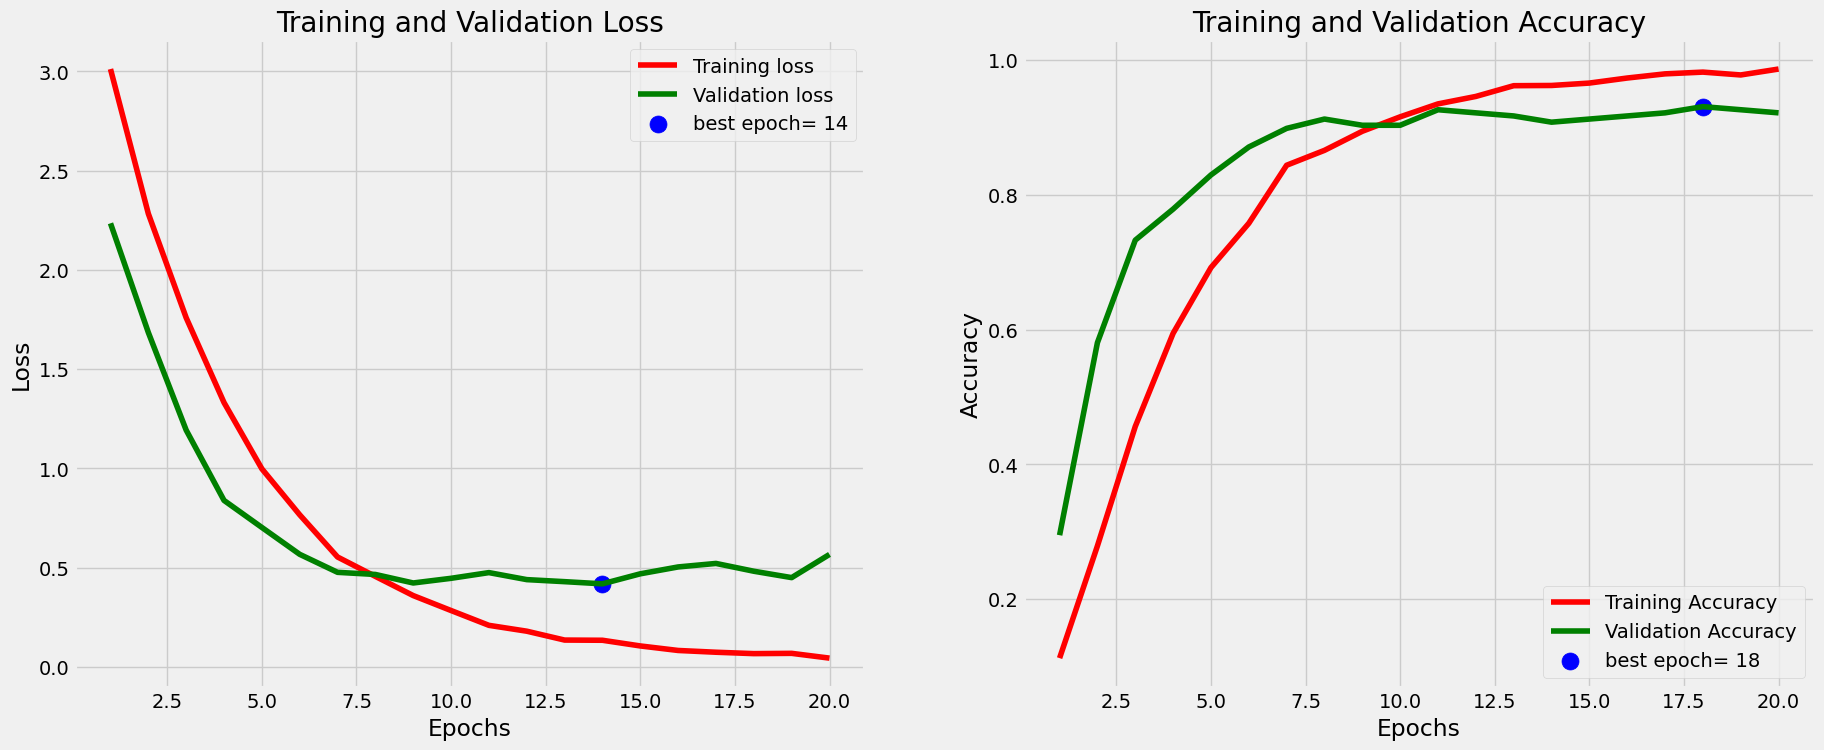

23/23 [==============================] - 9s 383ms/step - loss: 0.1842 - accuracy: 0.9594
accuracy on the test set is 95.94 %



In [ ]:
tr_plot(history,0)
save_dir=r'./'
subject='pest'
acc=model.evaluate( test_data, verbose=1, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))

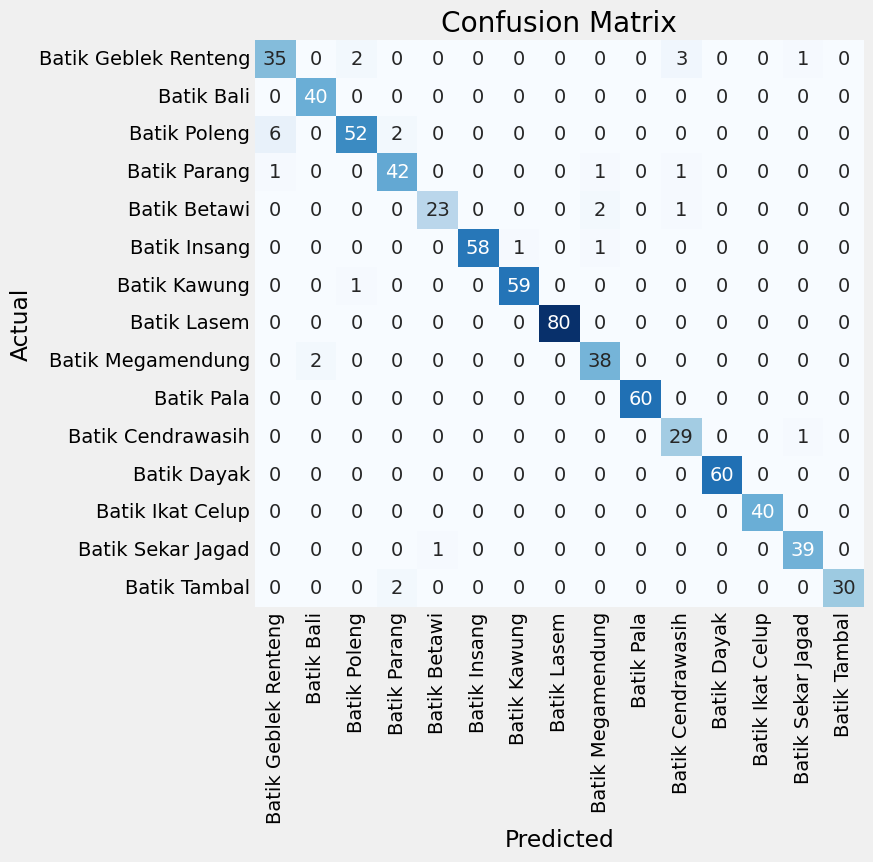

In [ ]:
if len(classes) <= 30:
    # create a confusion matrix 
    cm = confusion_matrix(y_test, yhat_test)
    length = len(classes)
    if length < 8:
        fig_width = 8
        fig_height = 8
    else:
        fig_width = int(length * 0.5)
        fig_height = int(length * 0.5)
    plt.figure(figsize=(fig_width, fig_height))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
    plt.xticks(np.arange(length) + 0.5, classes, rotation=90)
    plt.yticks(np.arange(length) + 0.5, classes, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


23/23 [==============================] - 8s 354ms/step


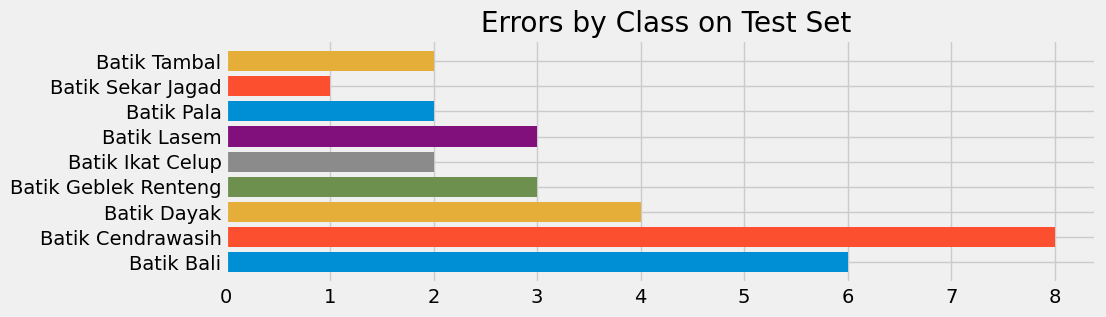

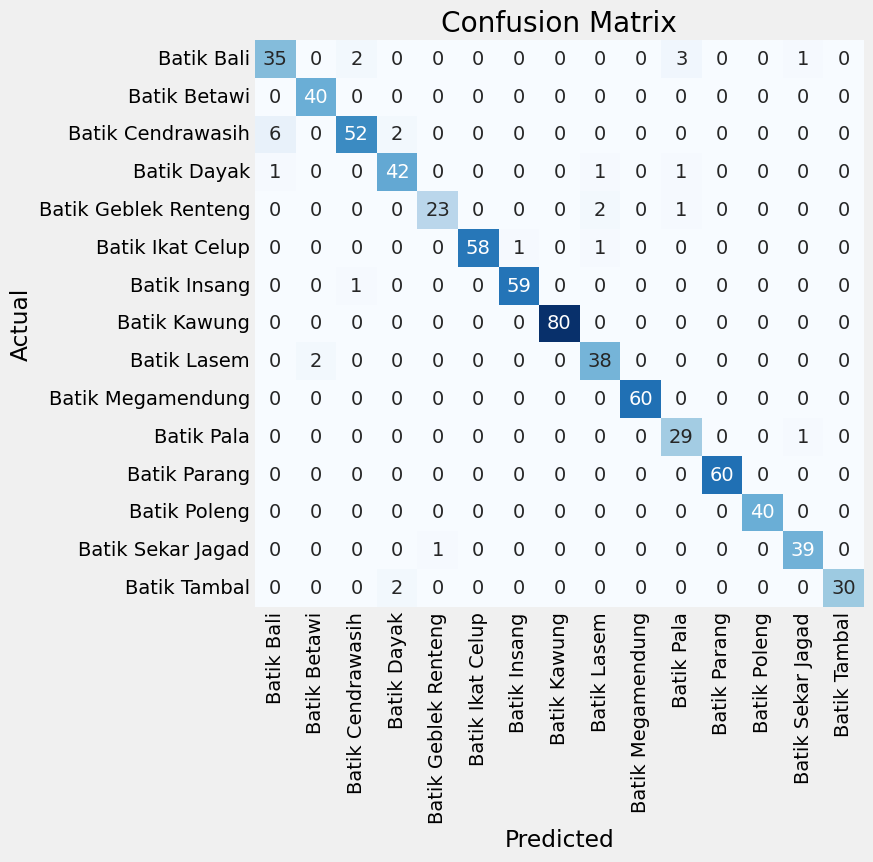

Classification Report:
----------------------
                       precision    recall  f1-score   support

          Batik Bali       0.83      0.85      0.84        41
        Batik Betawi       0.95      1.00      0.98        40
   Batik Cendrawasih       0.95      0.87      0.90        60
         Batik Dayak       0.91      0.93      0.92        45
Batik Geblek Renteng       0.96      0.88      0.92        26
    Batik Ikat Celup       1.00      0.97      0.98        60
        Batik Insang       0.98      0.98      0.98        60
        Batik Kawung       1.00      1.00      1.00        80
         Batik Lasem       0.90      0.95      0.93        40
   Batik Megamendung       1.00      1.00      1.00        60
          Batik Pala       0.85      0.97      0.91        30
        Batik Parang       1.00      1.00      1.00        60
        Batik Poleng       1.00      1.00      1.00        40
   Batik Sekar Jagad       0.95      0.97      0.96        40
        Batik Tambal  

In [ ]:
from sklearn.metrics import classification_report

print_code=0
preds=model.predict(test_data) 
print_info( test_data, preds, print_code, save_dir, subject ) 

In [ ]:
from sklearn.metrics import classification_report

# Assuming you have predicted labels stored in 'yhat_test' and true labels in 'y_test'
print(classification_report(y_test, yhat_test))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84        41
           1       0.95      1.00      0.98        40
           2       0.95      0.87      0.90        60
           3       0.91      0.93      0.92        45
           4       0.96      0.88      0.92        26
           5       1.00      0.97      0.98        60
           6       0.98      0.98      0.98        60
           7       1.00      1.00      1.00        80
           8       0.90      0.95      0.93        40
           9       1.00      1.00      1.00        60
          10       0.85      0.97      0.91        30
          11       1.00      1.00      1.00        60
          12       1.00      1.00      1.00        40
          13       0.95      0.97      0.96        40
          14       1.00      0.94      0.97        32

    accuracy                           0.96       714
   macro avg       0.95      0.95      0.95       714
weighted avg       0.96   

# Menyimpan Model

In [ ]:
model.save_weights("model_batik3_cnn_tf.h5")
